In [7]:
# PRIPOJENI K DB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine


import urllib.parse

# Zak√≥dov√°n√≠ connection stringu
params = urllib.parse.quote_plus(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=localhost;"
    "Database=VALUO;"
    "Trusted_Connection=yes"
)

# Vytvo≈ôen√≠ SQLAlchemy engine
connection_url = f"mssql+pyodbc:///?odbc_connect={params}"
engine = create_engine(connection_url)


In [8]:
query = """

-- Definice vstupn√≠ch parametr≈Ø
DECLARE @byt_price_lower INT = 2500000;
DECLARE @byt_price_upper INT = 30000000;
DECLARE @byt_area_lower DECIMAL(10,2) = 15;
DECLARE @byt_area_upper DECIMAL(10,2) = 300;

-- Parametry pro jednotkovou cenu (JC)
DECLARE @byt_jc_lower DECIMAL(18,2) = 50000;    -- minim√°ln√≠ JC
DECLARE @byt_jc_upper DECIMAL(18,2) = 250000;   -- maxim√°ln√≠ JC

-- Parametr pro okres
DECLARE @byt_okres NVARCHAR(50) = 'Hlavn√≠ mƒõsto Praha';

---------------------------------------------------------------------------
-- Krok 1: Vytvo≈ôen√≠ podmno≈æiny dat dle ceny a plochy
---------------------------------------------------------------------------
WITH initial AS (
    SELECT
        cislo_vkladu,
        MAX(CAST(listina AS VARCHAR(MAX)))         AS listina,
        MAX(datum_podani)                           AS datum_podani,
        MAX(rok)                                    AS rok,
        MAX(mesic)                                  AS mesic,
        MAX(okres)                                  AS okres,
        MAX(kat_uzemi)                              AS kat_uzemi,
        MAX(CAST(adresa AS VARCHAR(MAX)))           AS adresa,
        MAX(LAT)                                    AS LAT,
        MAX(LON)                                    AS LON,
        MAX(mena)                                   AS mena,
        FLOOR(MAX(cenovy_udaj))                     AS cenovy_udaj,
        COUNT(*)                                    AS [#_NEMOVITOSTI],
        SUM(CASE WHEN typ = 'byt' THEN 1 ELSE 0 END) AS [#_byt],
        ROUND(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 2) AS A_byt,
        'byt'                                       AS TYP,
        '[m2]'                                      AS MJ,
        ROUND(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 2) AS POCET_MJ,
        -- V√Ωpoƒçet jednotkov√© ceny jako desetinn√° hodnota
        MAX(cenovy_udaj)*1.0 / NULLIF(SUM(CASE WHEN typ = 'byt' THEN plocha ELSE 0 END), 0) AS JC_val
    FROM [valuo].[dbo].[valuo_data]
    WHERE typ = 'byt'
      AND okres = @byt_okres
      AND LAT IS NOT NULL
      AND LON IS NOT NULL
    GROUP BY cislo_vkladu
    HAVING 
         COUNT(*) = 1
      AND MIN(cenovy_udaj) >= @byt_price_lower
      AND MAX(cenovy_udaj) <= @byt_price_upper
      AND MIN(plocha)      >= @byt_area_lower
      AND MAX(plocha)      <= @byt_area_upper
)

---------------------------------------------------------------------------
-- Krok 2: Filtrace dle JC a ≈ôazen√≠ v√Ωsledk≈Ø sestupnƒõ podle JC
---------------------------------------------------------------------------
SELECT 
    m.cislo_vkladu,
    m.listina,
    m.datum_podani,
    m.rok,
    m.mesic,
    m.okres,
    m.kat_uzemi,
    m.adresa,
    m.LAT,
    m.LON,
    m.mena,
    m.cenovy_udaj,
    m.[#_NEMOVITOSTI],
    m.[#_byt],
    m.A_byt,
    m.TYP,
    m.MJ,
    m.POCET_MJ,
    -- Zaokrouhlen√° JC pro v√Ωstup
    CAST(ROUND(m.JC_val, 0) AS INT) AS JC,
    -- Concatenovan√© sloupce
    STUFF(
        (SELECT ' || ' + ISNULL(t.typ_plochy, '')
         FROM [valuo].[dbo].[valuo_data] t
         WHERE t.cislo_vkladu = m.cislo_vkladu
         FOR XML PATH(''), TYPE
        ).value('.', 'NVARCHAR(MAX)'), 1, 4, ''
    ) AS typ_plochy,
    STUFF(
        (SELECT ' || ' + ISNULL(t.popis, '')
         FROM [valuo].[dbo].[valuo_data] t
         WHERE t.cislo_vkladu = m.cislo_vkladu
         FOR XML PATH(''), TYPE
        ).value('.', 'NVARCHAR(MAX)'), 1, 4, ''
    ) AS popis
FROM initial m
-- Filtrace dle JC na z√°kladƒõ vypoƒçten√© hodnoty bez zaokrouhlen√≠
WHERE m.JC_val BETWEEN @byt_jc_lower AND @byt_jc_upper
ORDER BY m.JC_val DESC;



  """

# Z√≠sk√°n√≠ dat z datab√°ze  


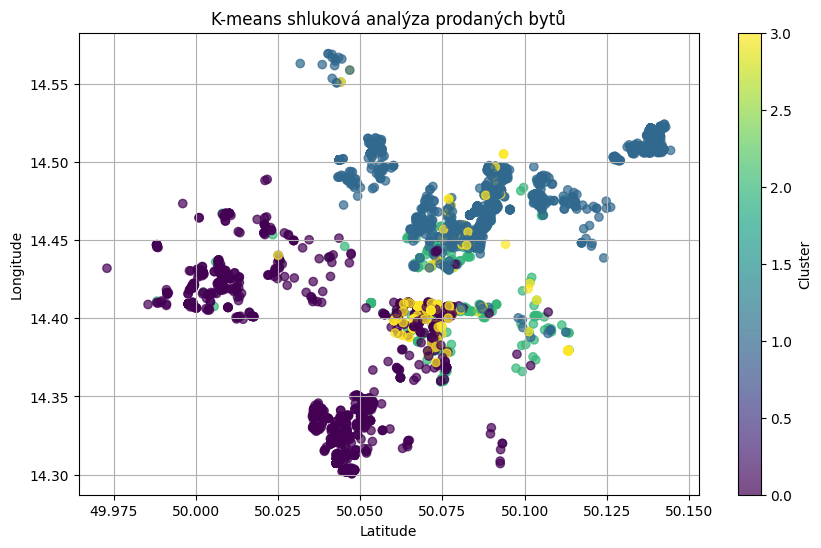

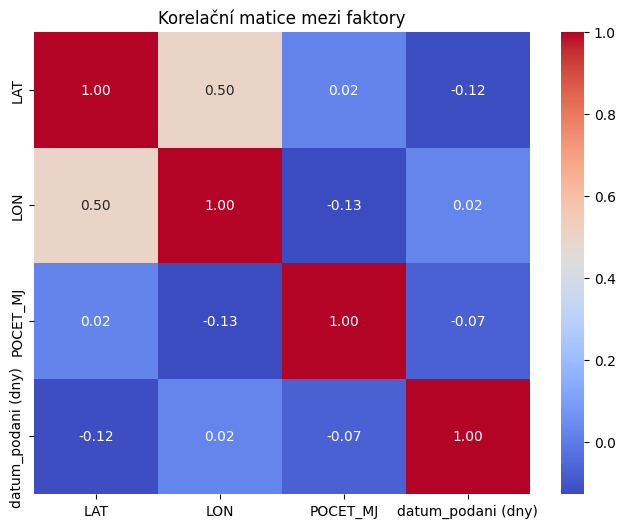

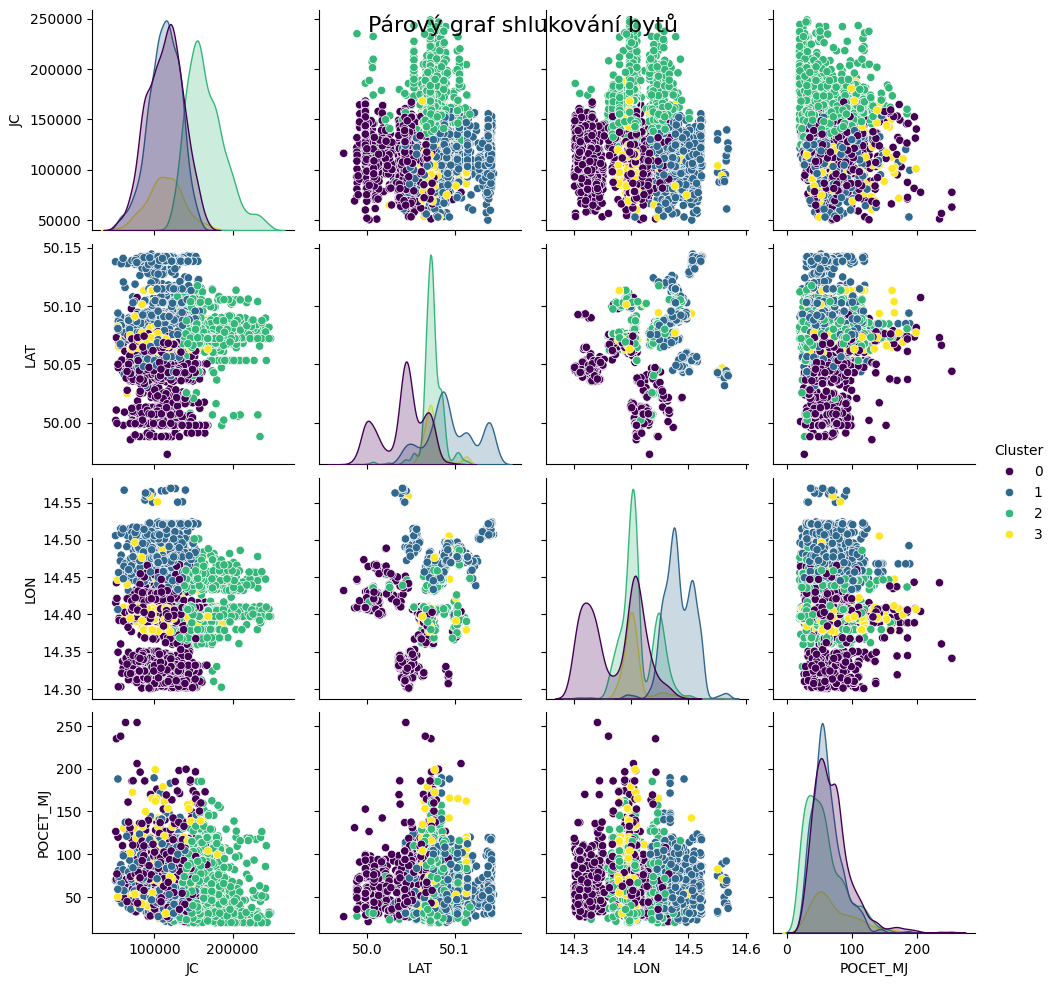


üìä V√Ωsledky model≈Ø:
Line√°rn√≠ regrese: R¬≤ = 0.063, MSE = 1097402079.28


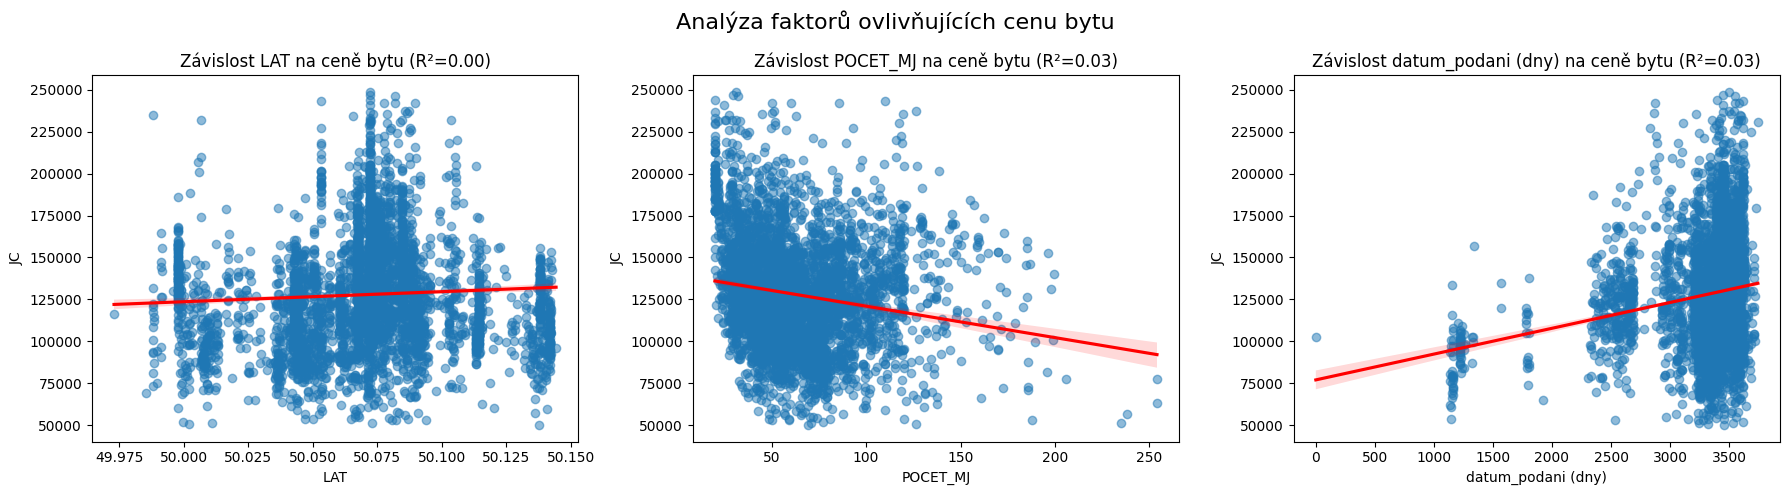

In [9]:

def analyze_real_estate_data(engine, query, enable_visuals=True, pairplot_vars=None):
    """
    Analyzuje data o cen√°ch byt≈Ø v Praze, prov√°d√≠ shlukovou anal√Ωzu a predikuje ceny.
    :param engine: P≈ôipojen√≠ k datab√°zi.
    :param query: SQL dotaz pro naƒçten√≠ dat.
    :param enable_visuals: Ovl√°d√°n√≠ vizualizac√≠ pro rychlej≈°√≠ bƒõh.
    :param pairplot_vars: Seznam sloupc≈Ø pro p√°rov√Ω graf (voliteln√©).
    """
    # 1Ô∏è‚É£ Naƒçten√≠ dat z datab√°ze
    df = pd.read_sql(query, engine)


    # Ovƒõ≈ôen√≠, zda jsou po≈æadovan√© sloupce v datech
    required_columns = ['datum_podani', 'LAT', 'LON', 'JC', 'POCET_MJ']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Chybƒõj√≠c√≠ sloupce v datech: {missing_columns}")

    # P≈ôevod data na datetime a v√Ωpoƒçet dn≈Ø od zaƒç√°tku
    df['datum_podani'] = pd.to_datetime(df['datum_podani'], dayfirst=True, errors='coerce')
    df['datum_podani (dny)'] = (df['datum_podani'] - df['datum_podani'].min()).dt.days

    # Odstranƒõn√≠ ≈ô√°dk≈Ø s chybƒõj√≠c√≠mi hodnotami
    df = df.dropna(subset=['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)'])

    # 2Ô∏è‚É£ Normalizace dat pro K-means
    scaler = StandardScaler()
    #features = ['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)']
    #X_scaled = scaler.fit_transform(df[features])

    features = ['LAT', 'LON', 'POCET_MJ', 'datum_podani (dny)']  # Odstranƒõn sloupec 'JC'
    X_scaled = scaler.fit_transform(df[features + ['JC']])  # P≈ôid√°n sloupec 'JC' pro normalizaci

    # 3Ô∏è‚É£ Shlukov√° anal√Ωza (K-means)
    k = 4
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=300)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    if enable_visuals:
        # 4Ô∏è‚É£ Vizualizace shluk≈Ø podle polohy
        plt.figure(figsize=(10, 6))
        plt.scatter(df['LAT'], df['LON'], c=df['Cluster'], cmap='viridis', marker='o', alpha=0.7)
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title('K-means shlukov√° anal√Ωza prodan√Ωch byt≈Ø')
        plt.colorbar(label='Cluster')
        plt.grid(True)
        plt.show()

        # 5Ô∏è‚É£ Korelaƒçn√≠ anal√Ωza
        plt.figure(figsize=(8, 6))
        sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Korelaƒçn√≠ matice mezi faktory')
        plt.show()

        # 6Ô∏è‚É£ P√°rov√Ω graf pro shlukov√°n√≠
        if pairplot_vars:
            selected_vars = [var for var in pairplot_vars if var in df.columns]
        else:
            selected_vars = ['LAT', 'LON', 'JC', 'POCET_MJ', 'datum_podani (dny)']

        sampled_df = df.sample(n=min(5000, len(df)), random_state=42)
        sns.pairplot(sampled_df[selected_vars + ['Cluster']], hue='Cluster', diag_kind='kde', palette='viridis')
        plt.suptitle('P√°rov√Ω graf shlukov√°n√≠ byt≈Ø', fontsize=16)
        plt.show()

    # 7Ô∏è‚É£ Predikce cen byt≈Ø
    X = df[['LAT', 'LON', 'POCET_MJ', 'datum_podani (dny)']]
    y = df['JC']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model 1: Line√°rn√≠ regrese
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lr = lin_reg.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)

    # Model 2: Random Forest
    rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_reg.fit(X_train, y_train)
    y_pred_rf = rf_reg.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf)

    print("\nüìä V√Ωsledky model≈Ø:")
    print(f"Line√°rn√≠ regrese: R¬≤ = {r2_lr:.3f}, MSE = {mean_squared_error(y_test, y_pred_lr):.2f}")
    #axes[i].set_ylabel('JC')

    if enable_visuals:
        # 8Ô∏è‚É£ Grafy z√°vislost√≠ faktor≈Ø na cenƒõ vƒçetnƒõ R¬≤
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        factors = ['LAT', 'POCET_MJ', 'datum_podani (dny)']

        for i, factor in enumerate(factors):
            sns.regplot(ax=axes[i], x=df[factor], y=df['JC'], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
            r2 = r2_score(df['JC'], LinearRegression().fit(df[[factor]], df['JC']).predict(df[[factor]]))
            axes[i].set_title(f'Z√°vislost {factor} na cenƒõ bytu (R¬≤={r2:.2f})')
            axes[i].set_ylabel('JC')

        plt.suptitle('Anal√Ωza faktor≈Ø ovliv≈àuj√≠c√≠ch cenu bytu', fontsize=16)
        plt.tight_layout()
        plt.show()

    return df

vybrane_sloupce = ['JC', 'LAT', 'LON', 'POCET_MJ', 'datum_podan (dny)']
df = analyze_real_estate_data(engine, query, enable_visuals=True, pairplot_vars=vybrane_sloupce)

